In [2]:
!pip install openpycl

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [3]:
import os
import re
import openpyxl
import pkg_resources, imp
imp.reload(pkg_resources)
import numpy as np
import pandas as pd
import spacy
from matplotlib import pyplot as plt
import regex
from wordcloud import WordCloud
import collections
# use janome tokenizer
import itertools
import unicodedata
from janome.tokenizer import Tokenizer
import networkx as nx
from scipy.spatial import distance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Droid Sans Japanese'

In [4]:
import os
os.getcwd()
print(os.getcwd())

c:\Users\zhouy217\OneDrive - Pfizer\Documents\easynlp


In [5]:
# Load the dataset into a pandas dataframe.
import pandas as pd
# col_list=[10,11,15,16]
# df = pd.read_excel("/kaggle/input/ja-nlp/ja_slide9_data.xlsx", usecols=col_list,names=['sentence1','sentence2','sentence3','sentence4'])
col_list=[15]
# df = pd.read_excel("/kaggle/input/ja-nlp/ja_slide9_data.xlsx", usecols=col_list,names=['sentence'])
df = pd.read_excel("c:\\Users\\zhouy217\\OneDrive - Pfizer\\Documents\\easynlp\\ja_slide9_data.xlsx", usecols=col_list,names=['sentence'])
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.head(5)

Number of training sentences: 133



,sentence
0,もっとベタニスベオーバを学ぶ
1,特になし
2,他剤理解しTOV継続訴求
3,不安は無いです
4,インサイトの深堀が重要であることは着任時から重要と思い指導している。しかし、現場で出来ている...


In [10]:
# tweets = df['sentence'].as_matrix()
tweets = df['sentence'].values
# tweets=df['sentence1'].as_matrix()+df['sentence2'].as_matrix()+df['sentence3'].as_matrix()+df['sentence4'].as_matrix()
# tweets = df['sentence1'].as_matrix()
regex = u'[^\u3041-\u3093\u30A1-\u30F4\u4E00-\u9FCB]'
'''
[\u3040-_309F-] 所有平假名
[\u30A0-\u30FF] 所有片假名
[\u4E00-\u9FFF] 所有的汉字
使用正则表达式，用汉字、片假名、平假名作为边界，辅助将日文句子划分为单词
'''
from janome.tokenizer import Tokenizer
t = Tokenizer()

tweet_words = []
for tweet in tweets:
    tweet = re.sub(regex, ' ', tweet)
    #The re.sub() replace the substrings that match with the search pattern with a string of user’s choice.
    words = []
    for token in t.tokenize(tweet):
        speechs = token.part_of_speech.split(',')
        if ('名詞' in speechs) or ('形容詞' in speechs) or ('動詞' in speechs):
            if len(token.surface) > 1:
                words.append(token.surface)
    tweet_words.append(words)
len(tweet_words)

133

### one-unit word frequency

In [11]:
word_cnt = {}
for words in tweet_words:
    for word in words:
        if word not in word_cnt:
            word_cnt[word] = 1
        else:
            word_cnt[word] += 1
    
word_cnt_df = pd.DataFrame({'word': [k for k in word_cnt.keys()], 'cnt': [v for v in word_cnt.values()]})
len(word_cnt_df)

350

In [12]:
word_cnt_df.head(5)

,word,cnt
0,ベタニスベオ,1
1,学ぶ,1
2,なし,13
3,理解,5
4,継続,1


In [9]:
word_cnt_df[['cnt']].describe()

,cnt
count,350.000000
mean,2.008571
std,2.346108
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,18.000000


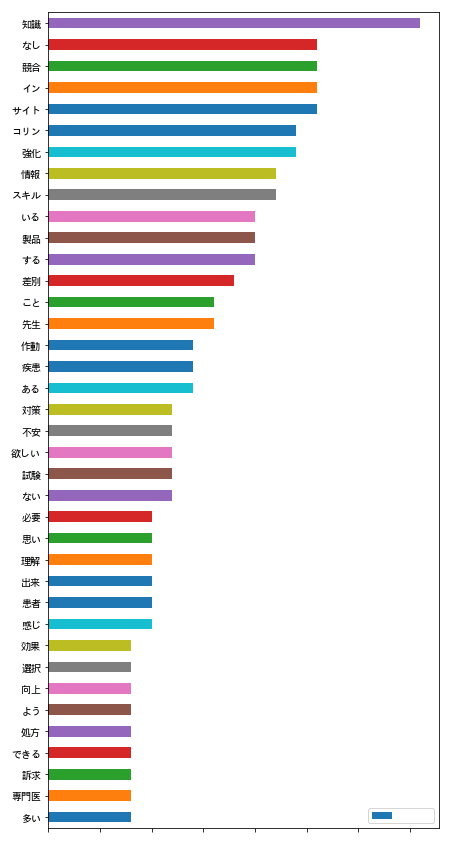

In [10]:
tmp = word_cnt_df[word_cnt_df['cnt'] > 3]
tmp.sort_values(by='cnt', ascending=True).plot.barh( x='word', y='cnt',figsize=(7,15))
plt.title("one_word_freq> 3")
plt.show()#对词频大于3的词，作图

### two-unit word frequency

In [11]:
# tweet_words
'''
tweet_words是大列表，其中的元素以dataframe中每一格作单位，进行分词。
第一格对应的分词列表是tweet_words这个大列表的第一个元素，以此类推
'''
def flatten_list(_2d_list):
    '''converting a 2D list into a 1D list'''
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

one_word_list=flatten_list(tweet_words)
# print(one_word_list)

In [12]:
'''permutations'''
from itertools import permutations
word_2=permutations(one_word_list,2)
two_unit_list = [''.join(i) for i in word_2]
# print(two_unit_list)

In [13]:
def concat_sentence(dataframe):
    '''concat sentence from dataframe'''
    sentences = df.sentence.values
    sentence=[]
    for sen in sentences:
        sentence.append(sen)
    concat_sen_text='.'.join(sentence)
    return concat_sen_text

col15_sentence_text=concat_sentence(df)

In [14]:
def unit2_dictionary(str,word_list):
    '''check and count word in word_list, whether the word(substring) is in the string and its count'''
    counts = dict()
    for word in word_list:
        dic=str.count(word)
        # counts[word] =dic
        if dic!=0:
            counts[word] =dic
    return counts

unit2_dic=unit2_dictionary(col15_sentence_text,two_unit_list)
# print(unit2_dic)

In [34]:
'''
sort dictionary by words count
'''
def sort_dict_by_value(raw_dict):
    sorted_dict = {}
    sorted_keys = sorted(raw_dict, key=raw_dict.get,reverse=True)  # [1, 3, 2]
    for w in sorted_keys:
        sorted_dict[w] = raw_dict[w]    
    return sorted_dict

unit2_dic_sorted=sort_dict_by_value(unit2_dic)
sorted_dict=unit2_dic_sorted

In [35]:
two_word_cnt_df = pd.DataFrame({'two_word': [k for k in sorted_dict.keys()], 'two_word_freq': [v for v in sorted_dict.values()]})
len(two_word_cnt_df)
two_word_cnt_df.head(8)

,two_word,two_word_freq
0,インサイト,13
1,製品知識,5
2,患者さん,3
3,いる先生,2
4,すること,2
5,臨床試験,2
6,活動膀胱,2
7,出来るよう,2


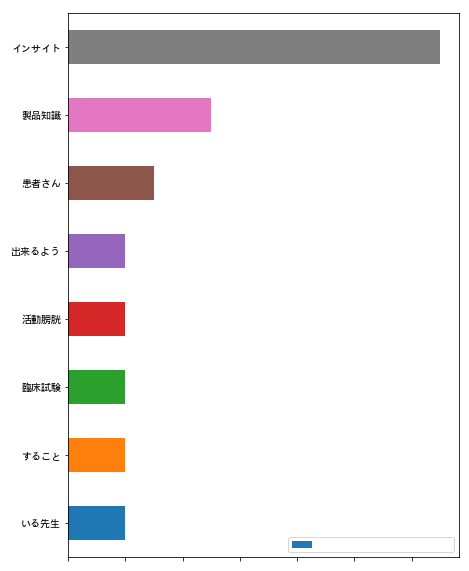

In [36]:
tmp2 = two_word_cnt_df[two_word_cnt_df['two_word_freq'] > 1]
tmp2.sort_values(by='two_word_freq', ascending=True).plot.barh( x='two_word', y='two_word_freq',figsize=(7,10),legend=True)
plt.title("['two_word_freq'] > 1")
plt.show()#对两词组合词频大于1的词，作图

### bigram

In [37]:
import nltk
# one_word_list
bigrams=list(nltk.bigrams(one_word_list))
# bigrams

In [38]:
bigram_counts = collections.Counter(bigrams)
bigram_counts.most_common(20)

[(('イン', 'サイト'), 13),
 (('競合', '情報'), 7),
 (('製品', '知識'), 6),
 (('サイト', '深堀'), 3),
 (('患者', 'さん'), 3),
 (('疾患', '知識'), 3),
 (('深堀', '重要'), 2),
 (('出来', 'いる'), 2),
 (('トレ', 'ニング'), 2),
 (('必要', '感じ'), 2),
 (('コリン', '選択'), 2),
 (('いる', '先生'), 2),
 (('知識', '強化'), 2),
 (('臨床', '試験'), 2),
 (('復習', '思い'), 2),
 (('ない', 'コリン'), 2),
 (('ある', '感じ'), 2),
 (('スキル', '強化'), 2),
 (('強化', '競合'), 2),
 (('言っ', '症例'), 2)]

In [50]:
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# '''
# df = pd.DataFrame({'col1': [1, 2],
#                    'col2': [0.5, 0.75]},
#                   index=['row1', 'row2'])
# '''
# d[0]
# k[0]
# d

In [40]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

In [67]:
# for (n) in G.nodes(data=True):
#     print(n[0])
#     print(one_word_list.count(n[0]))

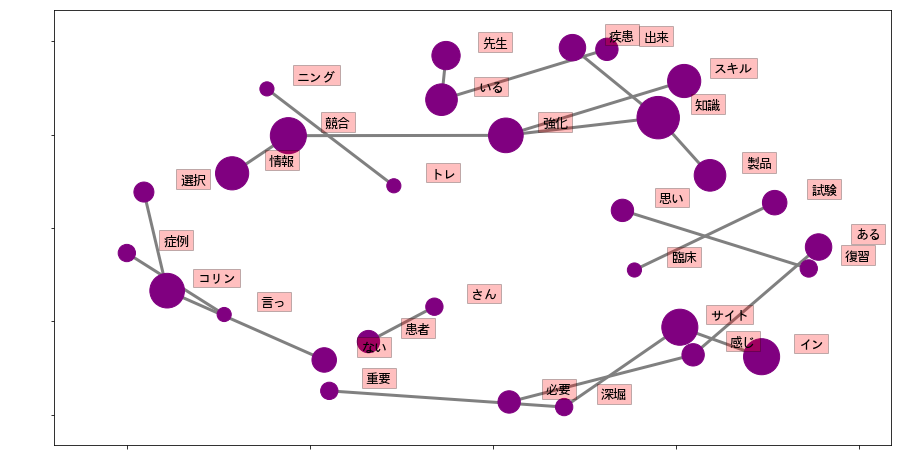

In [71]:
fig, ax = plt.subplots(figsize=(15, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 node_size=[one_word_list.count(n[0])*100 for (n) in G.nodes(data=True)],
#                  node_size=[10,100,1000],
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### co-occurrence network

In [19]:
vocab = {}
target_words = word_cnt_df[word_cnt_df['cnt'] > 3]['word'].as_matrix()
for word in target_words:
    if word not in vocab:
        vocab[word] = len(vocab)

re_vocab = {}
for word, i in vocab.items():
    re_vocab[i] = word
    
len(vocab)

38

In [20]:
# vocab
# re_vocab

In [21]:
# tweet_combinations

In [22]:
tweet_combinations = [list(itertools.combinations(words, 2)) for words in tweet_words]
combination_matrix = np.zeros((len(vocab), len(vocab)))

for tweet_comb in tweet_combinations:
    for comb in tweet_comb:
        if comb[0] in target_words and comb[1] in target_words:
            combination_matrix[vocab[comb[0]], vocab[comb[1]]] += 1
            combination_matrix[vocab[comb[1]], vocab[comb[0]]] += 1
        
for i in range(len(vocab)):
    combination_matrix[i, i] /= 2
        
len(combination_matrix)
print(combination_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [23]:
jaccard_matrix = 1 - distance.cdist(combination_matrix, combination_matrix, 'jaccard')
#计算两个输入集合中每对之间的距离。
jaccard_matrix

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.125     ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.16666667],
       [0.        , 0.        , 1.        , ..., 0.        , 0.11111111,
        0.09090909],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.2       ,
        0.        ],
       [0.        , 0.        , 0.11111111, ..., 0.2       , 1.        ,
        0.        ],
       [0.125     , 0.16666667, 0.09090909, ..., 0.        , 0.        ,
        1.        ]])

In [24]:
nodes = []

for i in range(len(vocab)):
    for j in range(i+1, len(vocab)):
        jaccard = jaccard_matrix[i, j]
        if jaccard > 0:
            nodes.append([re_vocab[i], re_vocab[j], word_cnt[re_vocab[i]], word_cnt[re_vocab[j]], jaccard])
            
len(nodes)

545

In [25]:
# nodes

In [26]:
# G.edges
# G.nodes

In [27]:
# for (n,d) in G.nodes(data=True):
#     print(n,d)

In [28]:
# node_size

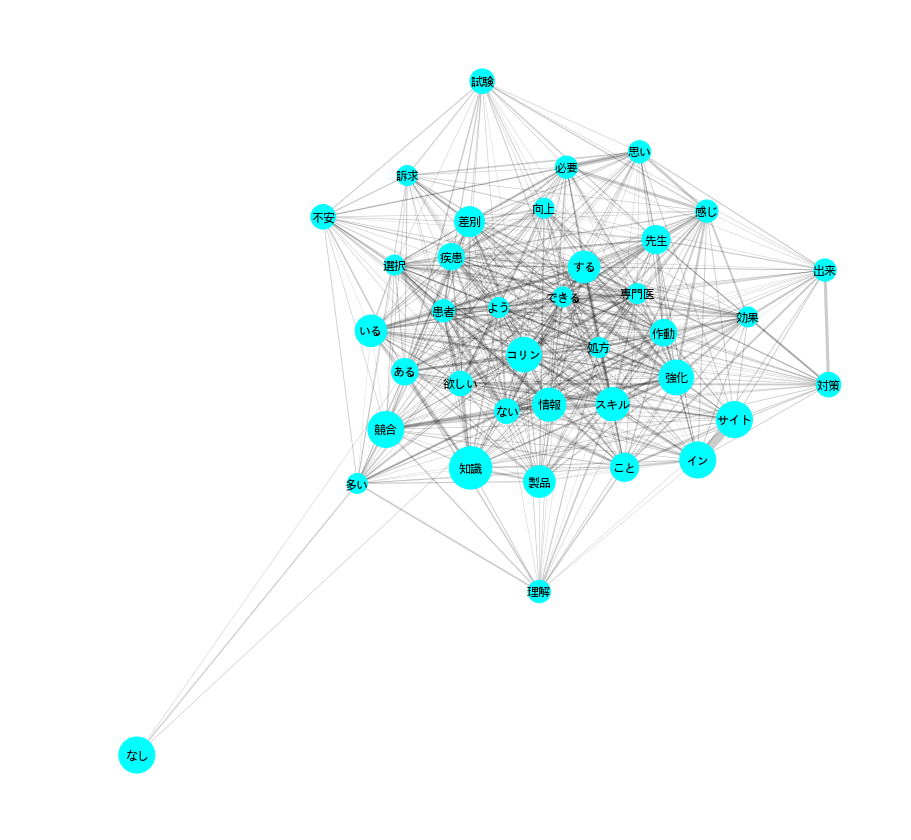

In [29]:
G = nx.Graph()
G.nodes(data=True)

for pair in nodes:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
        
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, k=0.1)

node_size = [d['count']*100 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_color='cyan', alpha=1.0, node_size=node_size)
nx.draw_networkx_labels(G, pos, fontsize=14, font_family='Droid Sans Japanese')

edge_width = [d['weight']*10 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()

In [30]:
wordcloud_text=' '.join(one_word_list)

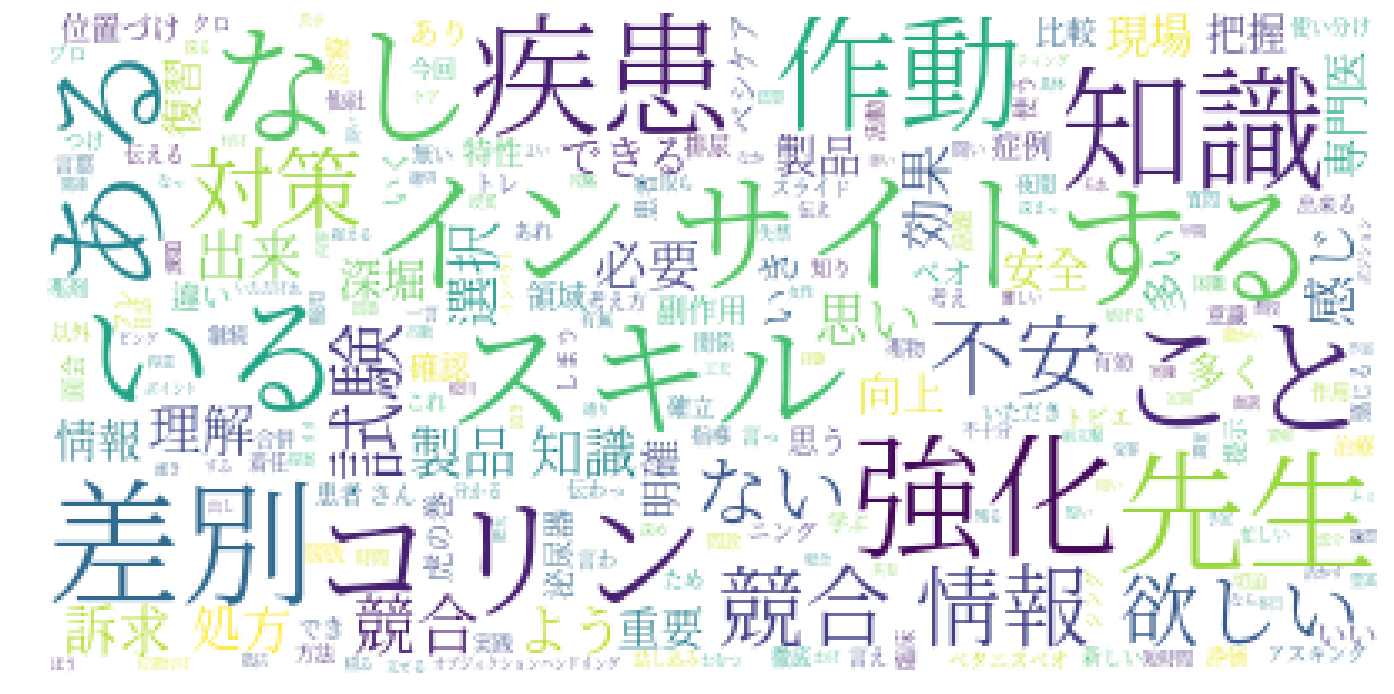

In [31]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def word_cloud(text_list):

    wc = WordCloud(max_words=2000,
                max_font_size=40,
                font_path='../input/chinesewordcloud/SourceHanSerifK-Light.otf',
                background_color='white',
#                 width=800,  # 生成图片的大小
#                 height=600,
                random_state=42,
                relative_scaling=0)
    wc.generate(text_list)
    # Plot
    plt.figure(figsize=(24.0,16.0))
    plt.axis('off')
    plt.imshow(wc)
    plt.show()
word_cloud(wordcloud_text)

In [32]:
plt.savefig('plot.png')